In [3]:
# Cài đặt các thư viện cần thiết
!pip install ultralytics
!pip install kagglehub
!pip install pyyaml
!pip install kagglehub

In [4]:
# Kiểm tra GPU
!nvidia-smi

# Import và kiểm tra pytorch với CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

Fri Feb  7 02:51:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   70C    P8             19W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Code để chạy trong cell mới sau khi đã train xong model

from google.colab import files
import tempfile
import os

def predict_uploaded_image(trainer):
    """
    Upload ảnh và dự đoán sử dụng model đã train
    """
    print("Hãy chọn ảnh để upload...")

    # Upload ảnh
    uploaded = files.upload()

    if not uploaded:
        print("Không có ảnh nào được upload!")
        return

    # Tạo temporary directory để lưu ảnh
    with tempfile.TemporaryDirectory() as temp_dir:
        for filename, content in uploaded.items():
            # Lưu ảnh vào temp directory
            temp_path = os.path.join(temp_dir, filename)
            with open(temp_path, 'wb') as f:
                f.write(content)

            print(f"\nDự đoán cho ảnh: {filename}")
            # Thực hiện dự đoán
            trainer.predict_and_visualize(temp_path, conf=0.25)

In [6]:
# Install Segment anything to focus to cell from uploaded image
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-dqlwftiy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-dqlwftiy
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [7]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import numpy as np
import cv2
from google.colab import files
import tempfile
import os
import matplotlib.pyplot as plt
from PIL import Image

class BloodCellSegmentPredictor:
    def __init__(self, trainer, sam_checkpoint="sam_vit_h_4b8939.pth"):
        """
        Khởi tạo predictor với SAM và YOLO model

        Args:
            trainer: BloodCellTrainer object đã train
            sam_checkpoint: Path tới SAM weights
        """
        self.trainer = trainer

        # Tải SAM model
        if not os.path.exists(sam_checkpoint):
            print("Downloading SAM checkpoint...")
            !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

        # Khởi tạo SAM
        device = "cuda" if torch.cuda.is_available() else "cpu"
        sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
        sam.to(device=device)

        # Khởi tạo mask generator
        self.mask_generator = SamAutomaticMaskGenerator(
            model=sam,
            points_per_side=32,
            pred_iou_thresh=0.9,
            stability_score_thresh=0.96,
            crop_n_layers=1,
            crop_n_points_downscale_factor=2,
            min_mask_region_area=100,  # Điều chỉnh để lọc vùng quá nhỏ
        )

    def extract_cell_regions(self, image):
        """
        Sử dụng SAM để phân đoạn các vùng tế bào

        Args:
            image: Numpy array ảnh BGR

        Returns:
            List of (cropped_image, bbox)
        """
        # Chuyển sang RGB cho SAM
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Tạo masks
        masks = self.mask_generator.generate(rgb_image)

        # Sắp xếp masks theo diện tích giảm dần
        sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

        cell_regions = []
        for mask in sorted_masks:
            # Lấy bbox
            bbox = mask['bbox']  # x, y, w, h

            # Tạo crop với padding
            pad = 10
            x1 = max(0, bbox[0] - pad)
            y1 = max(0, bbox[1] - pad)
            x2 = min(image.shape[1], bbox[0] + bbox[2] + pad)
            y2 = min(image.shape[0], bbox[1] + bbox[3] + pad)

            # Crop ảnh
            cropped = image[y1:y2, x1:x2]

            # Thêm vào list kết quả
            cell_regions.append({
                'crop': cropped,
                'bbox': (x1, y1, x2, y2),
                'mask': mask['segmentation']
            })

        return cell_regions

    def visualize_segments(self, image, cell_regions):
        """
        Hiển thị các vùng đã phân đoạn
        """
        # Copy ảnh để vẽ
        vis_image = image.copy()

        # Vẽ các bbox và mask
        for idx, region in enumerate(cell_regions):
            x1, y1, x2, y2 = region['bbox']
            mask = region['mask']

            # Vẽ bbox
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Vẽ mask với alpha blending
            colored_mask = np.zeros_like(image)
            colored_mask[mask] = [0, 0, 255]  # Màu đỏ cho mask
            vis_image = cv2.addWeighted(vis_image, 0.7, colored_mask, 0.3, 0)

            # Thêm label
            cv2.putText(vis_image, f"Cell {idx+1}", (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        return vis_image

    def predict_regions(self, cell_regions, conf=0.25):
        """
        Dự đoán loại tế bào cho từng vùng
        """
        predictions = []
        for region in cell_regions:
            crop = region['crop']
            results = self.trainer.model.predict(crop, conf=conf)

            # Lấy thông tin dự đoán
            if len(results[0].boxes) > 0:
                for box in results[0].boxes:
                    pred = {
                        'bbox': region['bbox'],
                        'class': self.trainer.model.names[int(box.cls[0])],
                        'conf': float(box.conf[0])
                    }
                    predictions.append(pred)

        return predictions

    def process_image(self, image_path):
        """
        Xử lý ảnh: phân đoạn -> dự đoán -> hiển thị
        """
        # Đọc ảnh
        image = cv2.imread(image_path)
        if image is None:
            print("Image canot read!")
            return

        # Phân đoạn các vùng tế bào
        print("Dêtcting segment cell ...")
        cell_regions = self.extract_cell_regions(image)

        if not cell_regions:
            print("Not found!")
            return

        print(f"Found {len(cell_regions)} cell range")

        # Hiển thị phân đoạn
        vis_image = self.visualize_segments(image, cell_regions)
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Segmented Cells')
        plt.show()

        # Dự đoán từng vùng
        print("\nnPredicing cell type...")
        predictions = self.predict_regions(cell_regions)

        # Hiển thị kết quả
        result_image = image.copy()
        for pred in predictions:
            x1, y1, x2, y2 = pred['bbox']
            label = f"{pred['class']} {pred['conf']:.2f}"

            # Vẽ bbox và label
            cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(result_image, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detection Results')
        plt.show()

def predict_uploaded_image_with_sam(trainer):
    """
    Upload và dự đoán ảnh với SAM + YOLO
    """
    print("Select image to predict...")

    # Khởi tạo predictor
    predictor = BloodCellSegmentPredictor(trainer)

    # Upload ảnh
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded!")
        return

    # Xử lý từng ảnh upload
    with tempfile.TemporaryDirectory() as temp_dir:
        for filename, content in uploaded.items():
            # Lưu ảnh
            temp_path = os.path.join(temp_dir, filename)
            with open(temp_path, 'wb') as f:
                f.write(content)

            print(f"\nnProcess image: {filename}")
            predictor.process_image(temp_path)


In [8]:
# Fix UTF-8 encoding
!apt-get update -qq
!apt-get install -qq locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

import os
os.environ["LANG"] = "en_US.UTF-8"
os.environ["LC_ALL"] = "en_US.UTF-8"

# Cài đặt các thư viện cần thiết
!pip install ultralytics kagglehub matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Tải SAM weights
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Preconfiguring packages ...
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../locales_2.35-0ubuntu3.9_all.deb ...
Unpacking locales (2.35-0ubuntu3.9) over (2.35-0ubuntu3.8) ...
Setting up locales (2.35-0ubuntu3.9) ...
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.
Processing triggers for man-db (2.10.2-1) ...
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-46t34ns6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-46t34ns6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dc

In [9]:
import locale
print("Current locale:", locale.getpreferredencoding())

import torch
print("CUDA available:", torch.cuda.is_available())

# Kiểm tra SAM weights
import os
print("SAM weights exist:", os.path.exists("sam_vit_h_4b8939.pth"))

Current locale: UTF-8
CUDA available: True
SAM weights exist: True


Dataset downloaded successfully to: /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1
Using dataset from: /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1
Created data.yaml at: /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/data.yaml
Found 0 images in dataset

Processing train split (0 images)...

Processing valid split (0 images)...

Processing test split (0 images)...
Ultralytics 8.3.72 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/data.yaml, epochs=10, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=blood_cell_detection, name=train, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, cl

train: Scanning /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/train/labels.cache... 6000 images, 0 backgrounds, 4202 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]

train: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/train/images/BA_100102_jpg_jpg.rf.6e4b04f6a9648e4fec638c256e78c61d.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 3. Possible class labels are 0-2
train: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/train/images/BA_101381_jpg_jpg.rf.fcd36dfb67f8eb03524b541275a94560.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 3. Possible class labels are 0-2
train: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/train/images/BA_101611_jpg_jpg.rf.3113346bea514a7b0fab00e1e0ec93dd.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 3. Possible class labels are 0-2
train: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/train/images/BA_102039_jpg_jpg.rf.0a081a01e296a64b82502822ef33c563.jpg: ignor

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/labels.cache... 1000 images, 0 backgrounds, 354 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_100695_jpg_jpg.rf.a166d50f1be1f41c3a9660ba7567eb88.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_101258_jpg_jpg.rf.fcfb2dc0c94e21f36159dc063d11aa82.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_102400_jpg_jpg.rf.b3bca773c5490a022481a4b2e464c8f3.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_103089_jpg_jpg.rf.47c7ece72592634a123d5b0458ace97b.jpg: ignoring corr

Plotting labels to blood_cell_detection/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to blood_cell_detection/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.25G     0.5662     0.9821     0.9553          6        640: 100%|██████████| 113/113 [00:13<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.20it/s]

                   all        646        653      0.967       0.95       0.97      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.06G     0.4911      0.441     0.8986          6        640: 100%|██████████| 113/113 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.50it/s]

                   all        646        653       0.98      0.989      0.989       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.06G     0.4769      0.387     0.8934          6        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.52it/s]

                   all        646        653      0.983      0.983      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.06G     0.4527     0.3581     0.8791          6        640: 100%|██████████| 113/113 [00:11<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.54it/s]

                   all        646        653      0.993      0.988      0.989      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.08G      0.445     0.3164     0.8785          6        640: 100%|██████████| 113/113 [00:10<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.41it/s]

                   all        646        653      0.998      0.982      0.994      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.08G     0.4229     0.3025     0.8647          6        640: 100%|██████████| 113/113 [00:10<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.57it/s]

                   all        646        653      0.993      0.989      0.992      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.08G     0.4185     0.2707     0.8618          6        640: 100%|██████████| 113/113 [00:10<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.52it/s]

                   all        646        653      0.995      0.989      0.994      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.08G     0.4085     0.2518     0.8563          6        640: 100%|██████████| 113/113 [00:10<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.52it/s]

                   all        646        653      0.997      0.989      0.994      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.06G     0.3919     0.2378     0.8461          6        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.72it/s]

                   all        646        653          1      0.989      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.06G     0.3847     0.2243     0.8523          6        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.71it/s]

                   all        646        653      0.995      0.989      0.994      0.971



10 epochs completed in 0.042 hours.
Optimizer stripped from blood_cell_detection/train/weights/last.pt, 6.3MB
Optimizer stripped from blood_cell_detection/train/weights/best.pt, 6.3MB

Validating blood_cell_detection/train/weights/best.pt...
Ultralytics 8.3.72 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.20it/s]


                   all        646        653      0.997      0.989      0.994      0.965
                   wbc        646        653      0.997      0.989      0.994      0.965
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to blood_cell_detection/train
Ultralytics 8.3.72 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/labels.cache... 1000 images, 0 backgrounds, 354 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_100695_jpg_jpg.rf.a166d50f1be1f41c3a9660ba7567eb88.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_101258_jpg_jpg.rf.fcfb2dc0c94e21f36159dc063d11aa82.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_102400_jpg_jpg.rf.b3bca773c5490a022481a4b2e464c8f3.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: WARNING ⚠️ /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/valid/images/MO_103089_jpg_jpg.rf.47c7ece72592634a123d5b0458ace97b.jpg: ignoring corr


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:06<00:00,  6.06it/s]


                   all        646        653      0.997      0.989      0.994      0.965
                   wbc        646        653      0.997      0.989      0.994      0.965
Speed: 0.2ms preprocess, 5.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to blood_cell_detection/train

=== Model Performance Metrics ===
Metric               Value
------------------------------
mAP50               0.9940
mAP50-95            0.9653
precision           0.9966
recall              0.9893

Processing image: PLATELET_603956_jpg_jpg.rf.ed9c200df7d73211c68ab0118e44ebae.jpg

image 1/1 /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/test/images/PLATELET_603956_jpg_jpg.rf.ed9c200df7d73211c68ab0118e44ebae.jpg: 640x640 1 platelets, 120.6ms
Speed: 3.2ms preprocess, 120.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


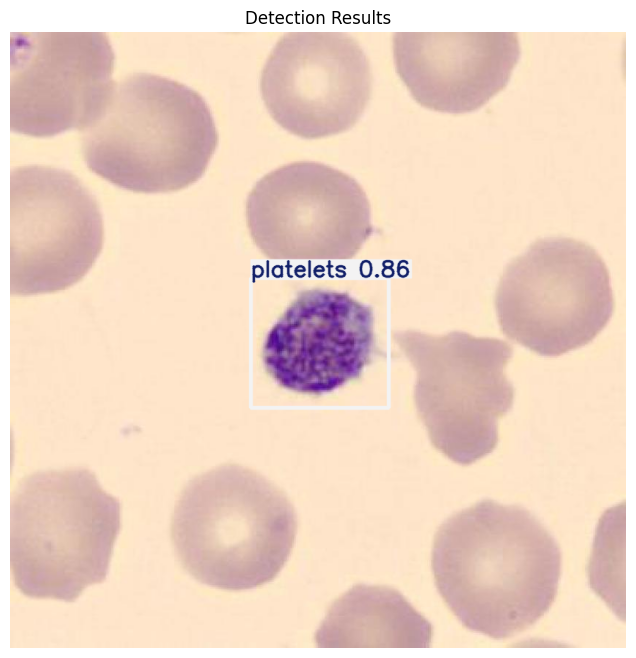


=== Detection Results ===
Class: platelets  Confidence: 0.8645

Processing image: PLATELET_630753_jpg_jpg.rf.2c8aa3aef7503aaa5f0c5bb7a4a48e8a.jpg

image 1/1 /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/test/images/PLATELET_630753_jpg_jpg.rf.2c8aa3aef7503aaa5f0c5bb7a4a48e8a.jpg: 640x640 1 platelets, 25.5ms
Speed: 3.1ms preprocess, 25.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


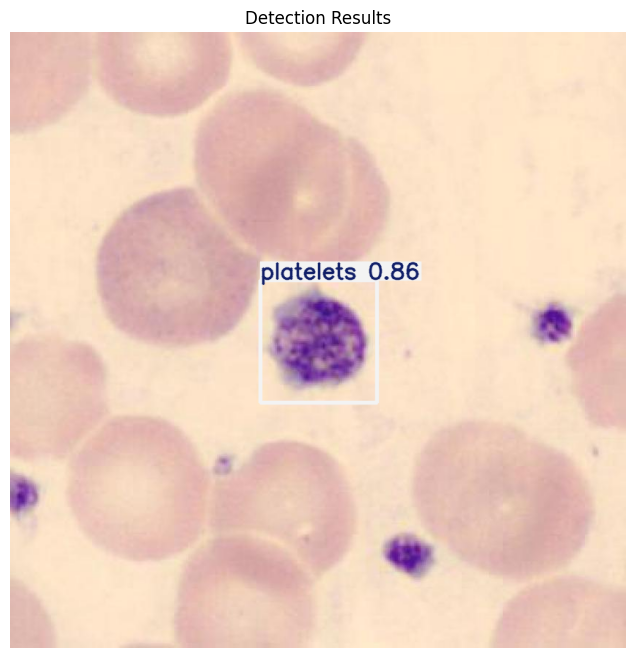


=== Detection Results ===
Class: platelets  Confidence: 0.8592

Processing image: LY_75542_jpg_jpg.rf.d2f7568bfad432a4086860bdc8caaef0.jpg

image 1/1 /root/.cache/kagglehub/datasets/quangnguynvnnn/bloodcell-yolo-format/versions/1/test/images/LY_75542_jpg_jpg.rf.d2f7568bfad432a4086860bdc8caaef0.jpg: 640x640 1 platelets, 26.5ms
Speed: 3.1ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


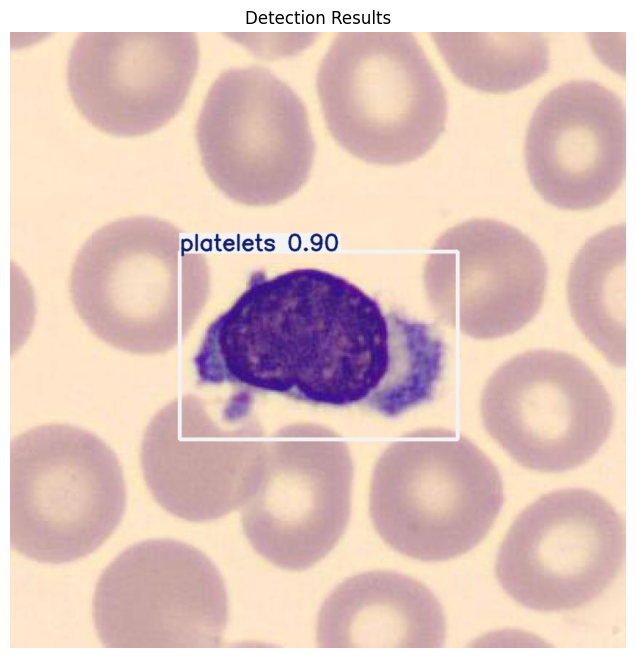


=== Detection Results ===
Class: platelets  Confidence: 0.9031
=== Blood Cell Detection with Segment Anything ===
Select image to predict...


Saving sinh-ly-mau-bach-cau.jpg to sinh-ly-mau-bach-cau.jpg

nProcess image: sinh-ly-mau-bach-cau.jpg
Dêtcting segment cell ...


/usr/local/lib/python3.11/dist-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  y_embed = grid.cumsum(dim=0) - 0.5
/usr/local/lib/python3.11/dist-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  x_embed = grid.cumsum(dim=1) - 0.5


Found 88 cell range


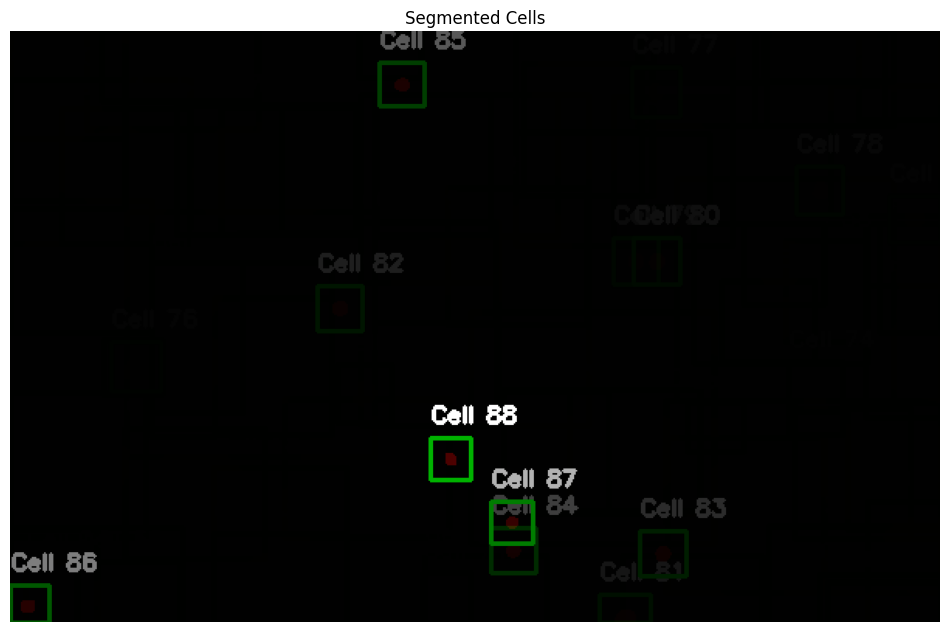


nPredicing cell type...

0: 640x640 (no detections), 28.5ms
Speed: 2.7ms preprocess, 28.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 (no detections), 171.4ms
Speed: 2.2ms preprocess, 171.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 (no detections), 175.3ms
Speed: 2.4ms preprocess, 175.3ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 (no detections), 25.1ms
Speed: 2.6ms preprocess, 25.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 (no detections), 162.9ms
Speed: 2.1ms preprocess, 162.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 (no detections), 24.6ms
Speed: 2.8ms preprocess, 24.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 (no detections), 24.4ms
Speed: 2.4ms preprocess, 24.4ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 (no detections), 24.7ms
Sp

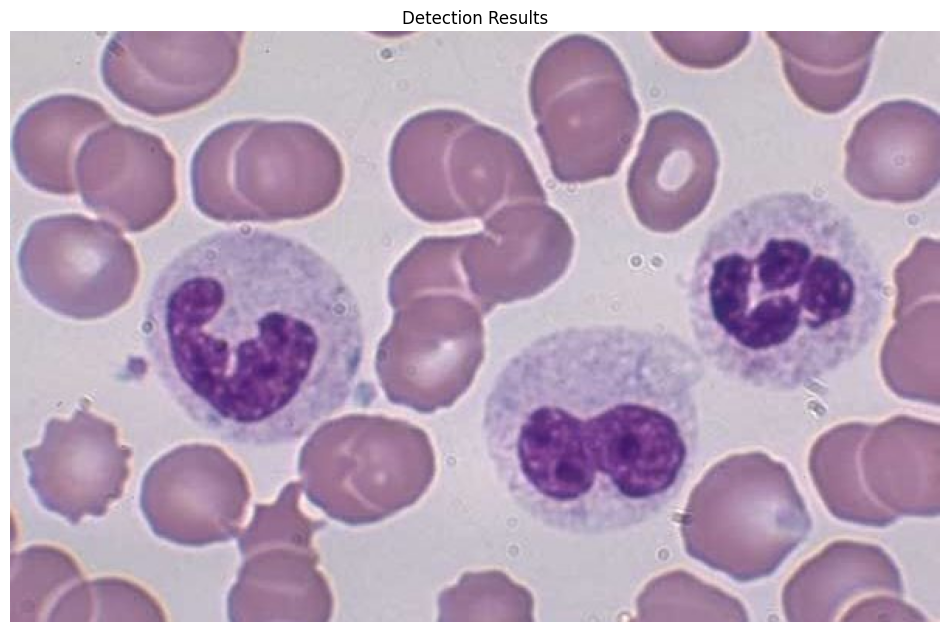

In [10]:
import kagglehub
from ultralytics import YOLO
import yaml
from pathlib import Path
import shutil
import random
import cv2
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt
import torch

def download_dataset():
    """
    Download dataset từ Kaggle và trả về đường dẫn
    """
    try:
        path = kagglehub.dataset_download("quangnguynvnnn/bloodcell-yolo-format")
        print(f"Dataset downloaded successfully to: {path}")
        return Path(path)
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise

class BloodCellTrainer:
    def __init__(self, model_name='yolov8n.pt'):
        """
        Khởi tạo trainer cho blood cell detection
        """
        self.data_dir = download_dataset()
        print(f"Using dataset from: {self.data_dir}")
        self.model = YOLO(model_name)

    def prepare_data_yaml(self, class_names):
        """
        Tạo file data.yaml cho training

        Args:
            class_names: List tên các class
        """
        data_yaml = {
            'path': str(self.data_dir.absolute()),
            'train': 'train/images',
            'val': 'valid/images',
            'test': 'test/images',
            'names': {i: name for i, name in enumerate(class_names)},
            'nc': len(class_names)
        }

        yaml_path = self.data_dir / 'data.yaml'
        with open(yaml_path, 'w') as f:
            yaml.dump(data_yaml, f)

        print(f"Created data.yaml at: {yaml_path}")
        return str(yaml_path)

    def split_dataset(self, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
        """
        Split dataset thành train/val/test
        """
        # Tạo thư mục
        splits = ['train', 'valid', 'test']
        for split in splits:
            for subdir in ['images', 'labels']:
                split_dir = self.data_dir / split / subdir
                split_dir.mkdir(parents=True, exist_ok=True)

        # List tất cả các file ảnh
        image_dir = self.data_dir / 'images'
        label_dir = self.data_dir / 'labels'

        image_files = list(image_dir.glob('*.jpg')) + list(image_dir.glob('*.png'))
        print(f"Found {len(image_files)} images in dataset")

        # Shuffle và split
        random.shuffle(image_files)
        n = len(image_files)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))

        splits_files = {
            'train': image_files[:train_end],
            'valid': image_files[train_end:val_end],
            'test': image_files[val_end:]
        }

        # Copy files
        for split, files in splits_files.items():
            print(f"\nProcessing {split} split ({len(files)} images)...")
            for img_path in files:
                # Copy image
                shutil.copy2(img_path,
                           self.data_dir / split / 'images' / img_path.name)

                # Copy corresponding label file
                label_path = label_dir / (img_path.stem + '.txt')
                if label_path.exists():
                    shutil.copy2(label_path,
                               self.data_dir / split / 'labels' / label_path.name)

    def train(self, epochs=100, batch_size=16, img_size=640):
        """
        Training model
        """
        # Load data.yaml path
        yaml_path = str(self.data_dir / 'data.yaml')

        # Training configuration
        self.model.train(
            data=yaml_path,
            epochs=epochs,
            batch=batch_size,
            imgsz=img_size,
            device='0' if torch.cuda.is_available() else 'cpu',
            patience=50,
            save=True,
            project='blood_cell_detection',
            name='train',
            exist_ok=True,
            pretrained=True,
            optimizer='Adam',
            lr0=0.001,
            weight_decay=0.0005,
            warmup_epochs=3,
            close_mosaic=10,
            augment=True,
            cache=False,
            workers=8,
            save_period=10,
            verbose=True
        )

    def validate(self):
        """
        Validate model và hiển thị metrics dễ đọc
        """
        yaml_path = str(self.data_dir / 'data.yaml')
        results = self.model.val(data=yaml_path, split='val')

        # Format metrics thành dạng dễ đọc
        metrics = {
            'mAP50': float(results.box.map50),
            'mAP50-95': float(results.box.map),
            'precision': float(results.box.mp),
            'recall': float(results.box.mr)
        }

        # Hiển thị metrics dạng bảng
        print("\n=== Model Performance Metrics ===")
        print(f"{'Metric':<15} {'Value':>10}")
        print("-" * 30)
        for metric, value in metrics.items():
            print(f"{metric:<15} {value:>10.4f}")

        return metrics

    def predict_and_visualize(self, image_path, conf=0.25):
        """
        Dự đoán và hiển thị kết quả trên ảnh
        """
        # Thực hiện dự đoán
        results = self.model.predict(image_path, conf=conf)

        # Lấy ảnh đã được vẽ boxes
        plotted_img = results[0].plot()

        # Chuyển từ BGR sang RGB
        plotted_img_rgb = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)

        # Hiển thị ảnh sử dụng matplotlib
        plt.figure(figsize=(12, 8))
        plt.imshow(plotted_img_rgb)
        plt.axis('off')
        plt.title('Detection Results')
        plt.show()

        # In kết quả dự đoán
        print("\n=== Detection Results ===")
        boxes = results[0].boxes
        for box in boxes:
            # Lấy tọa độ box
            x1, y1, x2, y2 = box.xyxy[0]
            # Lấy class và confidence
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            # Lấy tên class từ model
            class_name = self.model.names[cls]
            print(f"Class: {class_name:<10} Confidence: {conf:.4f}")

    def predict_folder(self, folder_path, num_images=5, conf=0.25):
        """
        Dự đoán nhiều ảnh từ một thư mục
        """
        # Lấy danh sách ảnh
        image_files = list(Path(folder_path).glob('*.jpg')) + list(Path(folder_path).glob('*.png'))

        if not image_files:
            print(f"No images found in {folder_path}")
            return

        # Chọn ngẫu nhiên số ảnh cần dự đoán
        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        # Dự đoán và hiển thị từng ảnh
        for img_path in selected_images:
            print(f"\nProcessing image: {img_path.name}")
            self.predict_and_visualize(str(img_path), conf=conf)

def main():
    # Khởi tạo trainer
    trainer = BloodCellTrainer(model_name='yolov8n.pt')

    # Chuẩn bị data.yaml
    class_names = ['rbc', 'wbc', 'platelets']
    trainer.prepare_data_yaml(class_names)

    # Split dataset
    trainer.split_dataset()

    # Training
    trainer.train(epochs=10)

    # Validate
    metrics = trainer.validate()

    # Dự đoán và hiển thị một số ảnh test
    test_folder = trainer.data_dir / 'test' / 'images'
    trainer.predict_folder(test_folder, num_images=3)

    # Sử dụng hàm
    # print("=== Blood Cell Detection - Image Upload & Prediction ===")
    # predict_uploaded_image(trainer)  # Sử dụng trainer object đã tạo trước đó

    # Sử dụng
    print("=== Blood Cell Detection with Segment Anything ===")
    predict_uploaded_image_with_sam(trainer)  # Sử dụng trainer object đã tạo trước đó

if __name__ == '__main__':
    main()